# 1. Process raw data

### Import some stuff

In [393]:
import glob
from collections import Counter

In [394]:
data_dir = '/Users/dominicbates/Documents/GitHub/jazz-standards-creator/data/iRb_v1-0/'
song_fnames_list = glob.glob(data_dir+"*.jazz")


### Function to process text

In [395]:
def process_song_data(text):
    song_data = []
    song_data_cleaned = ['==START==']
    
    for line in text:
        if '!!!OTL' in line:
            title = line[8:-1]
        if '!!!ODT' in line:
            year = line[8:-1]
        if '*M' in line:
            time_sig = line[2:-1]
        if ((line.startswith('!') == False) & 
            (line.startswith('*') == False) & 
            (line.startswith('\n') == False)):
            song_data.append(line[:-1])
            # --- Do some cleaning
            # Remove chord time
            if '=' not in line:
                
                # Remove chord length
                if line[1] == '.':
                    chord_length = line[0:2]
                    cleaned_line = line[2:-1]
                else:
                    chord_length = line[0:1]
                    cleaned_line = line[1:-1]

                # Turn - to flat sign
                cleaned_line = cleaned_line.replace('-','b')

                # Change chord names
                cleaned_line = cleaned_line.replace(':min','-')
                cleaned_line = cleaned_line.replace(':maj','maj')
                cleaned_line = cleaned_line.replace('add9', '9')
                
                # Remove complex chord extensions
                for extension in ['#11', '#9', 'b13', '#5', 'b9', '11', 'b6', '6', '13', '^9', 'alt', '^', '+', ';', ' ', '*', ':']:
                    cleaned_line = cleaned_line.replace(extension,'')
                    
                # Remove /... or (...)
                cleaned_line = cleaned_line.split('/', 1)[0]
                cleaned_line = cleaned_line.split('(', 1)[0]

                # Append cleaned lyrics
                song_data_cleaned.append(cleaned_line)
        # Add bars
        if '=' in line:
            cleaned_line = line.replace(' ','')
            song_data_cleaned.append(cleaned_line[:-1])
            
    song_data_cleaned[-1] = '==END=='
                
    return song_data_cleaned
            

### Loop and process all files

In [396]:
all_chords = []
all_song_data = []

for fname in song_fnames_list:
    with open(fname) as f:
        lines = f.readlines()
        
    song_data = process_song_data(lines)
    all_chords += song_data
    all_song_data.append(song_data)

In [397]:
# Check most common chords
counts = Counter(all_chords).most_common()
#counts

### Function to display chord sheet

In [483]:
def print_chords_pretty(song_data):
    
#     pretty_chords = ['']
#     bar_count = -1
#     for chord in song_data:
#         if (chord == '==') or (chord == '==START==') or (chord == '==END=='):
#             pretty_chords[-1] = pretty_chords[-1] + '|| '
#             bar_count+=1
#         elif chord == '=':
#             pretty_chords[-1] = pretty_chords[-1] + '| '
#             bar_count+=1
#         else: 
#             pretty_chords[-1] = pretty_chords[-1] + chord + ' '
            
#         if (bar_count == 4) or (chord == '=='):
#             new_line = True
#             pretty_chords[-1] = pretty_chords[-1] + '\n| '
#             bar_count = 0
            
    pretty_chords = ['']
    bar_count = 0
    first_bar = True
    
    for chord in song_data:
        # Change look of bar lines
        if (chord == '=='):
            chord = '||'
            bar_count += 1
        elif (chord == '==START==') or (chord == '==END=='):
            chord = '||'
        elif chord == '=':
            chord = '|'
            bar_count += 1
            
        # Add to list
        pretty_chords[-1] = pretty_chords[-1] + chord + ' '
        
        if first_bar == False:
            if (chord == '||') or (bar_count == 4):
                pretty_chords[-1] = pretty_chords[-1] + '\n'+chord+' '
                bar_count = 0
        else:
            first_bar = False
            
    print(pretty_chords[0][:-4])
    
    return 

In [400]:
# print_chords_pretty(song_data)

# 2. Create sample

In [401]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import copy

In [402]:
# Looking at https://github.com/Nwosu-Ihueze/poem_generator/blob/main/poem.ipynb
# also at https://levelup.gitconnected.com/lyrics-generation-using-lstm-5a5a0bcac4fa (mostly this)
max_tokens = 1000
max_seq_length = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_tokens, filters='', lower=False) # Remove filters (e.g. -), make sure recognises case
tokenizer.fit_on_texts(all_chords)

# Total words in tokenizer
n_tokens = len(tokenizer.word_index)


In [403]:

def create_input_sequences(all_song_data, max_seq_length, tokenizer, sample_probability=1):
    
    input_sequences = []

    # Loop through songs
    for n in range(len(all_song_data)):
        song_data = all_song_data[n]

        # Turn in to list of tokens
        song_data_tkn = tokenizer.texts_to_sequences([song_data])[0]

        # Calculate all input sequences 
        for i in range(1, len(song_data_tkn)): 

            # e.g. [0,0,0,1], [0,0,1,7], [0,1,7,3]
            if np.random.rand() <= sample_probability:
                # Get sequence
                n_gram_sequence = song_data_tkn[:i+1]
                # Cut to max length
                input_sequence = n_gram_sequence[-1*max_seq_length+1:]
                # Pad with 0s 
                padded_sequence = list(tf.keras.preprocessing.sequence.pad_sequences([input_sequence],
                                   maxlen = max_seq_length+1, padding='pre')[0])
                # Append to sequences
                input_sequences.append(padded_sequence) 

    # Turn to array
    input_sequences = np.array(input_sequences)

    # Split in to predictors and labels
    predictors, labels = input_sequences[:,:-1],input_sequences[:,-1]

    print('Size of input data is',len(predictors),'rows of length',len(predictors[0]))
    
    return predictors, labels


In [404]:
predictors, labels = create_input_sequences(all_song_data, max_seq_length, tokenizer)


Size of input data is 81382 rows of length 100


# 3. Define model

In [405]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 


In [406]:
def create_lstm(n_tokens,seq_len):
    model = Sequential()
    model.add(Embedding(n_tokens, 50, input_length=seq_len))
    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(150, return_sequences=True)))  
    # A dropout layer for regularisation
    model.add(Dropout(0.2))
    # Add another LSTM Layer
    model.add(LSTM(100)) 
    model.add(Dense(n_tokens/2, activation='relu'))  
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(n_tokens, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')  #(# Pick a loss function and an optimizer)
    print(model.summary())
    return model


In [407]:
model = create_lstm(n_tokens+1, max_seq_length) # +1 due to "unrecognised" token (I'm guessing - it breaks otherwise)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           13000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 300)          241200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_12 (Dense)             (None, 130)               13130     
_________________________________________________________________
dense_13 (Dense)             (None, 260)               34060     
Total params: 461,790
Trainable params: 461,790
Non-trainable params: 0
________________________________________________

# 4. Train model 

### Split in to trianing/test sample




In [411]:
# Get 80% in test, 20% in validation
n_training = int(len(predictors)*0.8)

# Predictors (x)
train_x = predictors[:n_training]
val_x = predictors[n_training:]

# Labels (y)
train_y = labels[:n_training]
val_y = labels[n_training:]



### Fit model with early stopping

In [412]:
#history = model.fit(predictors, labels, epochs = 10, verbose = 1)

from keras import callbacks

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
    
history = model.fit(train_x, train_y, batch_size = 128, 
                    epochs = 25, validation_data = (val_x, val_y), 
                    callbacks =[earlystopping])

Epoch 1/25
509/509 [==============================] - 247s 484ms/step - loss: 2.5294 - accuracy: 0.4349 - val_loss: 2.5027 - val_accuracy: 0.4525
Epoch 2/25
509/509 [==============================] - 244s 480ms/step - loss: 2.3768 - accuracy: 0.4694 - val_loss: 2.3429 - val_accuracy: 0.4858
Epoch 3/25
509/509 [==============================] - 248s 487ms/step - loss: 2.2157 - accuracy: 0.5033 - val_loss: 2.2288 - val_accuracy: 0.5097
Epoch 4/25
509/509 [==============================] - 253s 498ms/step - loss: 2.0956 - accuracy: 0.5250 - val_loss: 2.1509 - val_accuracy: 0.5245
Epoch 5/25
509/509 [==============================] - 263s 518ms/step - loss: 2.0162 - accuracy: 0.5401 - val_loss: 2.1101 - val_accuracy: 0.5312
Epoch 6/25
509/509 [==============================] - 267s 525ms/step - loss: 1.9547 - accuracy: 0.5509 - val_loss: 2.0681 - val_accuracy: 0.5416
Epoch 7/25
509/509 [==============================] - 272s 535ms/step - loss: 1.8936 - accuracy: 0.5629 - val_loss: 2.0508 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


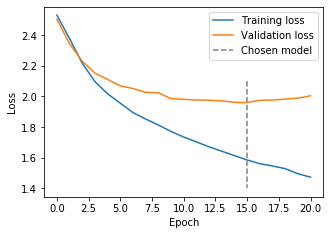

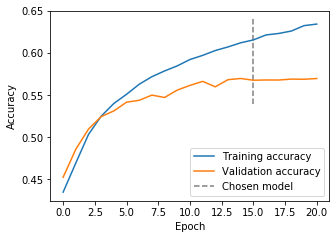

In [521]:
print(history.history.keys())

import matplotlib.pyplot as plt

plt.figure(figsize=(5,3.5))
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.vlines(15,2.1,1.4,linestyle='dashed',alpha=0.5,label='Chosen model')
plt.legend()

plt.figure(figsize=(5,3.5))
plt.plot(history.history['accuracy'],label='Training accuracy')
plt.plot(history.history['val_accuracy'],label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.vlines(15,0.54,0.64,linestyle='dashed',alpha=0.5,label='Chosen model')
plt.legend()

# import pickle

In [420]:
# Save model (saved)
#model.save('/Users/dominicbates/Documents/GitHub/jazz-standards-creator/model_2nd_nov_earlystopping.model')

# from tensorflow import keras
# model = keras.models.load_model('/Users/dominicbates/Documents/GitHub/jazz-standards-creator/model_2nd_nov_earlystopping.model')


INFO:tensorflow:Assets written to: /Users/dominicbates/Documents/GitHub/jazz-standards-creator/model_2nd_nov_earlystopping.model/assets


INFO:tensorflow:Assets written to: /Users/dominicbates/Documents/GitHub/jazz-standards-creator/model_2nd_nov_earlystopping.model/assets


In [422]:
# Save training history
import pickle

# with open('/Users/dominicbates/Documents/GitHub/jazz-standards-creator/model_2nd_nov_earlystopping.history', 'wb') as handle:
#     pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/Users/dominicbates/Documents/GitHub/jazz-standards-creator/model_2nd_nov_earlystopping.history', 'rb') as handle:
#     b = pickle.load(handle)

# 5. Make predictions

In [489]:
def predict(input_sequence, temperature = 1):
    # Sample from pdf (temp 1 is normal sampling, higher temp means more variability)
    pdf = model.predict(np.array([input_sequence]))[0]
    a = np.log(pdf) / temperature
    a = 0.99999 * np.exp(a) / np.sum(np.exp(a)) # 0.99999 stops some floating point rounding error bugs when sum > 1
    return np.argmax(np.random.multinomial(1,a,1))



def generate_chords(temperature = 1, seed = None, print_output=False):

    # Set seed
    if seed != None:
        np.random.seed(seed)
        
    # Set up input
    output_sequence = [tokenizer.texts_to_sequences(['==START=='])[0][0]]
    input_sequence = [0]*max_seq_length
    input_sequence[-1] = tokenizer.texts_to_sequences(['==START=='])[0][0]
    end = False
    n_steps = 0

    # Generate next chord and keep going
    while end == False:
        # Get next prediction and update arrays
        next_chord = predict(input_sequence, temperature)
        output_sequence.append(next_chord)
        input_sequence = input_sequence[(-1*(max_seq_length-1)):]
        input_sequence.append(next_chord)

        # Stop if '==END==' character is predicted, or if n_steps is really big!
        n_steps += 1
        if n_steps >= 200:
            break
            print('Error - no end predicted')
        elif next_chord == tokenizer.texts_to_sequences(['==END=='])[0]:
            break
        
    output_chords = tokenizer.sequences_to_texts([output_sequence])[0].split(' ')
    
    if print_output == True:
        print('Printing chords for AI generated jazz')
        print('Seed:',seed,', Temperature:',temperature)
        #print(pretty_chords[0][:-4])
        print('----------------------------')
        print_chords_pretty(output_chords)
    
        
    return output_chords
    


In [528]:
for n in range(75,100):
    output_chords = generate_chords(temperature = 0.9, seed=n+1, print_output = True)
    print('\n\n')

Printing chords for AI generated jazz
Seed: 76 , Temperature: 0.9
----------------------------
|| Cmaj7 | Cmaj7 | E7 | E7 | 
| D-7 | D-7 | G7 | G7 || 
|| D-7 | D-7 | D-7 | G7 | 
| Cmaj7 | Cmaj7 | D-7 | G7 | 
| Cmaj7 | Cmaj7 | E-7 | A7 | 
| D-7 | G7 | Cmaj7 | C7b5 | 
| Fmaj7 | Bh7 E7 | A-7 | D7 | 
| D-7 | G7 | C | D-7 G7 || 



Printing chords for AI generated jazz
Seed: 77 , Temperature: 0.9
----------------------------
|| Eh7 | A7 | D7 | D7 | 
| G7 | G7 | C7 | C7 || 
|| A-7 | D7 | A-7 | D7 | 
| A-7 | D7 | A-7 | D7 | 
| Gmaj7 | D-7 G7 || 
|| C | C | G7 | G7 | 
| E7 A7 | D- | Bh7 | E7 | 
| A-7 | D9 | F# | Ab7 | 
| Dh7 | G7 || 



Printing chords for AI generated jazz
Seed: 78 , Temperature: 0.9
----------------------------
|| G-7 | C7 | Ah7 D-7 | G7 | 
| C7 | G-7 C7 | F | D-7 G7 || 
|| G-7 C7 | F | C-7 F7 | Bbmaj7 Bo7 | 
| F9 | A-7 | D7 | Eb7 | 
| Eb7 | Bb7 | Eb7 | D- | 
| F7 | Bbmaj7 | Bbmaj7 D7 | G-7 | 
| C7 | F7 | F7 | Bbmaj7 | 
| G-7 | C7 | G-7 C7 || 



Printing chords for AI gener

In [529]:
for n in range(25,50):
    output_chords = generate_chords(temperature = 0.7, seed=n+1, print_output = True)
    print('\n\n')

Printing chords for AI generated jazz
Seed: 26 , Temperature: 0.7
----------------------------
|| Fmaj7 | G-7 C7 | Fmaj7 | G-7 C7 | 
| Fmaj7 | G-7 C7 | Fmaj7 | G-7 C7 || 
|| Fmaj7 | F-7 | Bbmaj7 | Bbmaj7 | 
| G-7 | C7 | Fmaj7 | Fmaj7 || 
|| G-7 | C7 | F | G-7 C7 || 
|| F | F | Fmaj7 | Bh7 E7 | 
| A-7 D-7 | G-7 C7 | F | G-7 C7 || 



Printing chords for AI generated jazz
Seed: 27 , Temperature: 0.7
----------------------------
|| Gmaj7 | Gmaj7 | Gmaj7 | Gmaj7 | 
| C-7 | F7 | Bbmaj7 | Bb7 | 
| E-7 | A7 | D- | Eh7 A7 | 
| D-7 | G7 | Cmaj7 | Cmaj7 || 
|| Bbmaj7 | Bbmaj7 | Bbmaj7 | Bbmaj7 | 
| Bbmaj7 | Bbmaj7 | Bbmaj7 | Bbmaj7 | 
| Bbmaj7 | G-7 | D-7 | D-7 | 
| D-7 | G7 | D-7 | G7 | 
| Cmaj7 | Cmaj7 | Cmaj7 | Cmaj7 | 
| D-7 | G7 | Cmaj7 | Cmaj7 | 
| Cmaj7 | Cmaj7 | A-7 | D7 | 
| D-7 | G7 | Cmaj7 | Bb-7 Eb7 | 
| A-7 | D7 | D-7 | G7 | 
| Cmaj7 | A7 | D-7 | G7 | 
| Cmaj7 | Cmaj7 | Cmaj7 | Ebo7 | 
| D-7 | G7 | Cmaj7 | D-7 | 
| E-7 | A7 | D-7 | G7 | 
| Cmaj7 | C7 | Fmaj7 | E | 
| Bh7 | E7 | A-7 

Printing chords for AI generated jazz
Seed: 47 , Temperature: 0.7
----------------------------
|| Fmaj7 | Fmaj7 | Fmaj7 | Fmaj7 | 
| Fmaj7 | Fmaj7 | Fmaj7 | Fmaj7 | 
| A-7 | D7 | G-7 | C7 | 
| Fmaj7 | Fmaj7 | G-7 | C7 | 
| Fmaj7 | Fmaj7 | F7 | F#o7 | 
| G-7 | C7 | A-7 | D7 | 
| G-7 | C7 | Fmaj7 | G-7 C7 || 



Printing chords for AI generated jazz
Seed: 48 , Temperature: 0.7
----------------------------
|| F- | F- | Bb7 | Eb7 | 
| Bb7 | Eb7 | Bb | Bb || 
|| G- | C- | F7 | F7 || 
|| Bbmaj7 | Bbmaj7 | D7 | D7 | 
| G- | G7 || 
|| C- | C- | Co7 | C- | 
| B7 | B7 | Bb7 | F7 | 
| F7 | F7 | Bb-maj7 | Gb7 | 
| F- | Bb7 | Eb7 | Eb7 | 
| Gh7 | C7 | F-7 | Bb7 | 
| F7 | F7 | Bb7 | Eb7 | 
| A | G7 || 



Printing chords for AI generated jazz
Seed: 49 , Temperature: 0.7
----------------------------
|| C | D-7 G7 | Cmaj7 | G-7 C7 | 
| Fmaj7 | Fmaj7 | E-7 | A7 | 
| D-7 | G7 || 
|| E-7 A7 | D-7 | E-7 A7 | D-7 G7 | 
| Cmaj7 | Ebo7 | D-7 G7 | E-7 A7 | 
| D-7 | G7 | D-7 | G7 | 
| D-7 | Dh7 G7 | C | D-7 G7

In [530]:
for n in range(25,50):
    output_chords = generate_chords(temperature = 1, seed=n+1, print_output = True)
    print('\n\n')

Printing chords for AI generated jazz
Seed: 26 , Temperature: 1
----------------------------
|| Fmaj7 | C7 || 
|| A-7 | E7 | A- | A-maj7 | 
| A-7 | D7 | D7 | D-7 Gsus | 
| Bb7 | Cmaj7 | A-7 | D7 | 
| D7 | D7 | D7sus | D7 | 
| D7 | G7 | G7 | C | 
| C || 



Printing chords for AI generated jazz
Seed: 27 , Temperature: 1
----------------------------
|| Bb7 | Eb7 | Bb7 | Bb7 Bb7 | 
| F-7 | F7 | C-7 F7 | C-7 F7 Bb7 || 
|| E || 
|| Bb-7 Eb7 || 
|| Abmaj7 | G-7 C7 | F-7 | Bb7 | 
| F-7 Bb7 | A-7 D7 || 
|| Dbmaj7 Cb7 | F#o7 G7 | C7 C-7 | G7 C7 | 
| F7 Bsus | E F7 || 



Printing chords for AI generated jazz
Seed: 28 , Temperature: 1
----------------------------
|| Ab7 | Ab7 | D7 | G7 Gb7 | 
| Ch7 | F-7 | F-7 | Bb7 || 
|| Db7 | D7 || 
|| Ah7 | D7 | G7 | G7 | 
| Cmaj7 | C | Dbmaj7 | F7 | 
| A-7 | D7 || 
|| G | G | B-7 | E7 | 
| A7 | A7 | A-7 | D7 | 
| G | G || 
|| G | B-7 | E7 A7 | E7 | 
| E7 | A-7 | Bh7 | E7 | 
| D7 | D7 D#o7 | C- | G- || 



Printing chords for AI generated jazz
Seed: 29 , Tem

Printing chords for AI generated jazz
Seed: 50 , Temperature: 1
----------------------------
|| Bb7 | Bb7 | Ebmaj7 | Eb- | 
| Bb7 | Bb7 | F7sus | E9 || 
|| Eb Ab | Eb A | G Bb | Bb Bb7 || 





In [461]:
output_chords = generate_chords(temperature = 1, seed=100, print_output = True)

Printing chords for: A.I. Generated Jazz 

|| Bbmaj7 | A-7 D7 | Ebmaj7 | Eh7 A7 | 
| D-7 | G7 | C7 F7 | Bbmaj7 || 
|| C-7 | C-7 | Ah7 D7 | D-7 G7 | 
| C-7 | F7 | Bbmaj7 Ab7 | G-7 C7 | 
| C-7 | Eb-7 Ab7 | D-7 G-7 | D-7 A7 | 
| Dh7 | G7 || 


In [389]:
output_chords = generate_chords(temperature = 1, seed=1, print_output = True)

Printing chords for: A.I. Generated Jazz 

|| Bbmaj7 | Bb-7 Eb7 | G- | Ah7 Ab7 | 
| Dbmaj7 | D7sus D7 | Gmaj7 E7 A | Bb | 
| C-7 Ab Gb | Ebmaj7 Bo7 | C-7 | Bb7 | 
| E-9 | Bb-7 | Ab F7 | B | 
| Fh7 | Eb7 | F-7 | Bb7 | 
| Ebmaj7 | Eb-7 | Eb7 || 
|| Ab7 | Ab7 | Db7 | Eh7 Eb7 D7 | 
| G7 || 


In [490]:
output_chords = generate_chords(temperature = 0.9, seed=7, print_output = True)

Printing chords for AI generated jazz
Seed: 7 , Temperature: 0.9
----------------------------
|| G-7 | C7 | A-7 | D7 | 
| G-7 | C7 | A-7 | D7 | 
| G-7 | C7 | Fmaj7 | Fmaj7 || 


In [491]:
output_chords = generate_chords(temperature = 0.9, seed=8, print_output = True)

Printing chords for AI generated jazz
Seed: 8 , Temperature: 0.9
----------------------------
|| Fmaj7 | Fmaj7 | D7 | D7 | 
| G-7 | C7 | Fmaj7 | F-7 Bb7 || 
|| Ebmaj7 | Ab-7 Db7 | G-7 | C7 | 
| Fmaj7 | Fmaj7 || 
|| Ebmaj7 | Eb-7 Ab7 || 
|| Dh7 G7 | C7 | G-7 | C7 | 
| F | Ab-7 D7 || 
|| Gmaj7 | Bb-7 Eb7 | F | G-7 C7 | 
| F | Ah7 D7 | G-7 | C7 | 
| A-7 | D7 | G-7 | Bb- C7 | 
| Fmaj7 | C-7 F7 | Bbmaj7 | F-7 Bb7 | 
| A-7 | D7 || 


In [492]:
output_chords = generate_chords(temperature = 0.9, seed=9, print_output = True)

Printing chords for AI generated jazz
Seed: 9 , Temperature: 0.9
----------------------------
|| C | G7 | C | Cmaj7 | 
| Eh7 A7 | D-7 G7 | C G7 | C || 
|| Fmaj7 | Fmaj7 | D-7 | G7 | 
| Cmaj7 | C#o7 | E-7 | A7 | 
| D-7 | G7 | Cmaj7 | Cmaj7 || 
